In [ ]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_train.shape,y_train.shape,x_test.shape,y_test.shape

11490434/11490434 [==============================] - 2s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model


img_a_inp = Input((28, 28), name='img_a_inp')
img_b_inp = Input((28, 28), name='img_b_inp')

In [ ]:
def get_cnn_block(depth):
  return Sequential([Conv2D(depth, 3, 1),
                     BatchNormalization(),
                     ReLU()])

DEPTH = 64
cnn = Sequential([Reshape((28, 28, 1)),
                  get_cnn_block(DEPTH),
                  get_cnn_block(DEPTH*2),
                  get_cnn_block(DEPTH*4),
                  get_cnn_block(DEPTH*8),
                  GlobalAveragePooling2D(),
                  Dense(64, activation='relu')])

feature_vector_a = cnn(img_a_inp)
feature_vector_b = cnn(img_b_inp)

concat = Concatenate()([feature_vector_a, feature_vector_b])

dense = Dense(64, activation='relu')(concat)
output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=[img_a_inp, img_b_inp], outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_a_inp (InputLayer)         [(None, 28, 28)]     0           []                               
                                                                                                  
 img_b_inp (InputLayer)         [(None, 28, 28)]     0           []                               
                                                                                                  
 sequential_4 (Sequential)      (None, 64)           1586496     ['img_a_inp[0][0]',              
                                                                  'img_b_inp[0][0]']              
                                                                                                  
 concatenate (Concatenate)      (None, 128)          0           ['sequential_4[0][0]',       

In [ ]:
import numpy as np

random_indices = np.random.choice(x_train.shape[0], 300, replace=False)

x_train_sample, y_train_sample = x_train[random_indices], y_train[random_indices]

x_train_sample.shape, y_train_sample.shape

((300, 28, 28), (300,))

In [ ]:
import itertools

def make_paired_dataset(x, y):
  x_pairs, y_pairs = [], []

  tuples = [(x1, y1) for x1, y1 in zip(x, y)]
  
  for t in itertools.product(tuples, tuples):
    pair_a, pair_a = t
    img_a, label_a = t[0]
    img_b, label_b = t[1]

    new_label = int(label_a == label_b)

    x_pairs.append([img_a, img_b])
    y_pairs.append(new_label)
  
  x_pairs = np.array(x_pairs)
  y_pairs = np.array(y_pairs)

  return x_pairs, y_pairs

In [ ]:
make_paired_dataset(x_train_sample, y_train_sample)

(array([[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
 
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]],
 
 
        [[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
 
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]],
 
 
        [[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0

In [ ]:
x_train_pairs, y_train_pairs = make_paired_dataset(x_train_sample, y_train_sample)

x_train_pairs.shape, y_train_pairs.shape

((90000, 2, 28, 28), (90000,))

In [ ]:
random_indices = np.random.choice(x_test.shape[0], 150, replace=False)

x_test_sample, y_test_sample = x_test[random_indices], y_test[random_indices]

x_test_sample.shape, y_test_sample.shape

((150, 28, 28), (150,))

In [ ]:
x_test_pairs, y_test_pairs = make_paired_dataset(x_test_sample, y_test_sample)

x_test_pairs.shape, y_test_pairs.shape

((22500, 2, 28, 28), (22500,))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3)

In [ ]:
model.fit(x=[x_train_pairs[:, 0, :, :], x_train_pairs[:, 1, :, :]],
          y=y_train_pairs,
          validation_data=([x_test_pairs[:, 0, :, :], 
                            x_test_pairs[:, 1, :, :]],
                           y_test_pairs),
          epochs=4,
          batch_size=32,
          callbacks=[es])

Epoch 1/4
2813/2813 [==============================] - 141s 46ms/step - loss: 0.2037 - accuracy: 0.9223 - val_loss: 0.1941 - val_accuracy: 0.9218
Epoch 2/4
2813/2813 [==============================] - 130s 46ms/step - loss: 0.0437 - accuracy: 0.9836 - val_loss: 0.2402 - val_accuracy: 0.9443
Epoch 3/4
2813/2813 [==============================] - 130s 46ms/step - loss: 0.0149 - accuracy: 0.9951 - val_loss: 0.2130 - val_accuracy: 0.9532
Epoch 4/4
2813/2813 [==============================] - 130s 46ms/step - loss: 0.0084 - accuracy: 0.9973 - val_loss: 0.2432 - val_accuracy: 0.9355


In [ ]:
img_A, img_B = x_test[0], x_test[17]
label_A, label_B = y_test[0], y_test[17]

label_A, label_B

(7, 7)

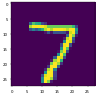

In [ ]:
import matplotlib.pyplot as plt

plt.figure(dpi=28)
plt.imshow(img_A)

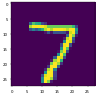

In [ ]:
plt.figure(dpi=28)
plt.imshow(img_A)

In [ ]:
model.predict([img_A.reshape((1, 28, 28)), 
               img_B.reshape((1, 28, 28))]).flatten()[0]

1/1 [==============================] - 0s 422ms/step


0.9968104